# Classification

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objs as go
import seaborn as sns


import cv2
import csv
from bs4 import BeautifulSoup

import lazypredict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from skimage.feature import local_binary_pattern

from category_encoders import TargetEncoder,  CountEncoder

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import warnings

# Download nltk packages if not already downloaded
# nltk.download()

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))

warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
df_origin = pd.read_csv('datasets/train/games-classification-dataset.csv')

## Target Variable Encoding

In [3]:
def rate_preprocess(_df):
  # Define mapping dictionary
  mapping = {
    'Low': 0, 
    'Intermediate': 1,
    'High': 2}

  # Apply mapping to column
  _df['Rate'] = _df['Rate'].apply(lambda x: mapping[x])
  
  return _df

df_origin = rate_preprocess(df_origin)

## Data Gathering

### Download the icons

In [4]:
# Download the images
def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


def download_icons(_df):
    # Convert to string
    _df['Icon URL'] = _df['Icon URL'].astype(str)

    # Create a folder to store the images
    if not os.path.exists('icons/train'):
        os.makedirs('icons/train')

    # Download the images if they don't exist
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        if not os.path.exists('icons/train/' + str(i) + '.png'):
            download_image(row['Icon URL'], 'icons/train/' + str(i) + '.png')

    # Replace the URL with the icon filename which is the index of the row
    _df['Icon URL'] = _df.apply(lambda row : f'icons/train/{row.name}.png', axis=1)
    
    return _df


### Download the reviews

In [5]:
def web_scrapping(_df):
    data = pd.DataFrame(columns=["ID", "Reviews"])
    
    for url, id_value in zip(_df['URL'], _df['ID']):
        # Redirect to the reviews page
        url += "?see-all=reviews"
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:  
            soup = BeautifulSoup(response.text, 'html.parser')
            blocks = soup.findAll("blockquote")
            review_list = []
            for blockquote in blocks:
                review = blockquote.find('p').text
                review_list.append(review)
                
            if len(review_list) != 0:
                new_row = {'ID': id_value, "Reviews": review_list}
                data = data.append(new_row, ignore_index=True)
    
    data.to_csv('datasets/train/reviews.csv', index=False)

In [6]:
def reviews_splitting(data):

    for i in range (len(data)):
        data.at[i, 'Reviews'] = data.at[i, "Reviews"].split("',")
        data.at[i,"ID"] =data.at[i,"ID"]
        
    data = data.explode('Reviews')
    return data

In [7]:
def reviews_cleaning(data):
  # Convert text to lowercase
  data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())

  # Replace newline characters with an empty string
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\n', ' ', x))

  # Remove black squares
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\u25a0', '', x))

  # Remove special characters and punctuations
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

  # Remove numbers
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.split() if not any(char.isdigit() for char in word)]))

  # Remove extra whitespaces
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))

  # Remove stop words
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]))

  # Remove empty strings
  data = data[data['Reviews'].apply(lambda x: len(x)>0)]
  
  # Group by ID
  data = data.groupby('ID')['Reviews'].apply(list).reset_index()
  
  return data

In [8]:
def download_reviews(_df):

    # Web scrapping to get the html of the reviews, Only run once
    # web_scrapping(_df)

    df_reviews = pd.read_csv('datasets/train/reviews.csv')

    df_reviews = reviews_splitting(df_reviews)

    df_reviews = reviews_cleaning(df_reviews)

    # Merge The Sentiment with the original dataset
    _df = _df.merge(df_reviews, on='ID', how='left')

    return _df

## Data Exploration

### General information

In [9]:
# df.head()

In [10]:
# df.info()

In [11]:
# df.isnull().sum()

### Genres

In [12]:
def genres_analysis(_df):
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    genre_counts = _df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
    print(genre_counts)


### Developer

In [13]:
def dev_analysis(_df):

    print(_df['Developer'].value_counts())
    
    # print the number developers with more than 1 game
    print(len(_df['Developer'].value_counts()[_df['Developer'].value_counts() > 1]))

    print(_df['Developer'].unique().size)

### Dates

In [14]:
def date_analysis(_df):
    # Plot the distribution of the date columns

    fig, ax = plt.subplots(5, 2, figsize=(20, 20))

    # df = date_preprocessing(df)

    # game_age distribution
    sns.histplot(_df['game_age'], ax=ax[0, 0])
    sns.boxplot(_df['game_age'], ax=ax[0, 1], orient='h')

    # last_update distribution
    sns.histplot(_df['last_update'], ax=ax[1, 0])
    sns.boxplot(_df['last_update'], ax=ax[1, 1], orient='h')

    # Original Release Date distribution
    sns.histplot(_df['Original Release Date'], ax=ax[2, 0])
    sns.boxplot(_df['Original Release Date'], ax=ax[2, 1], orient='h')

    # Current Version Release Date distribution
    sns.histplot(_df['Current Version Release Date'], ax=ax[3, 0])
    sns.boxplot(_df['Current Version Release Date'], ax=ax[3, 1], orient='h')

    # maintaning_period distribution
    sns.histplot(_df['maintaning_period'], ax=ax[4, 0])
    sns.boxplot(_df['maintaning_period'], ax=ax[4, 1], orient='h')

    plt.show()

# Date outliers are legitimate data points that are worth keeping, they are not errors nor anomalies

### Languages

In [15]:
def lang_analysis(_df):
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    langs_counts = _df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
    print(langs_counts[1:30])


In [16]:
# df.hist(figsize=(15, 15))

## Dates preprocessing

In [17]:
def date_preprocess(_df, test=False):
        # Use dateparse to parse the dates
    _df['Original Release Date'] = pd.to_datetime(
        _df['Original Release Date'], format='%d/%m/%Y', errors='coerce')
    _df['Current Version Release Date'] = pd.to_datetime(
        _df['Current Version Release Date'], format='%d/%m/%Y', errors='coerce')

    # Convert the datetime to ordinal
    _df['Original Release Date'] = _df['Original Release Date'].apply(
        lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    _df['Current Version Release Date'] = _df['Current Version Release Date'].apply(
        lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Impute missing values using simple imputer with median strategy
    if test:
        simple_imputer = pickle.load(open('imputers/classification/date_simple.pkl', 'rb'))
    else:
        simple_imputer = SimpleImputer(strategy='median').fit(_df[['Original Release Date', 'Current Version Release Date']])
        pickle.dump(simple_imputer, open('imputers/classification/date_simple.pkl', 'wb'))
    
    _df[['Original Release Date', 'Current Version Release Date']] = simple_imputer.transform(_df[['Original Release Date', 'Current Version Release Date']])
    
    # Create a new column with the age of the game
    _df['game_age'] = datetime.now().toordinal() - _df['Original Release Date']

    # Create a new column with the time since the last update
    _df['last_update'] = datetime.now().toordinal() - _df['Current Version Release Date']
    
    # Create a new column with the maintaning period
    _df['maintaning_period'] = _df['game_age'] - _df['last_update']

    return _df

## Developer preprocessing

### Target encoding approach

In [18]:
def dev_preprocess_target_enc(_df, test=False):
    """Preprocesses and encodes the 'Developer' column using target encoding.

    Args:
        df (DataFrame): DataFrame (either train or test, depending on the value of test)
        test (bool, optional): Boolean flag indicating whether the data is for testing (True) or training (False). Defaults to False.

    Returns:
        DataFrame: the preprocessed DataFrame with the new 'dev_avg' column
    """

    # Convert Developer column to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')  
      
    # Replace Developers with less than 2 games with 'Other'
    if not test:
        dev_counts = _df['Developer'].value_counts()
        other = dev_counts[dev_counts < 2].index
        _df['Developer'] = _df['Developer'].replace(other, np.nan)

    # Perform target encoding on Developer column
    if test:
        te = pickle.load(open('encoders/classification/dev_te.pkl', 'rb'))
    else:
        te = TargetEncoder(cols=['Developer'], smoothing=20, handle_missing='return_nan').fit(_df[['Developer']], _df['Rate'])
        pickle.dump(te, open('encoders/classification/dev_te.pkl', 'wb'))

    _df['dev_avg'] = te.transform(_df[['Developer']])
    
    # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/classification/dev_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['dev_avg']])
        pickle.dump(knn, open('imputers/classification/dev_knn.pkl', 'wb'))
    
    _df['dev_avg'] = knn.transform(_df[['dev_avg']])
    _df['dev_avg'] = _df['dev_avg'].astype(float)
    
    return _df


### Frequency encoding approach

In [19]:
def dev_preprocess_freq_enc(_df, test):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    if not test:
        ce = CountEncoder(cols=['Developer']).fit(_df[['Developer']])
        pickle.dump(ce, open('encoders/classification/dev_ce.pkl', 'wb'))
    else:
        ce = pickle.load(open('encoders/classification/dev_ce.pkl', 'rb'))
    
    _df['dev_freq'] = ce.transform(_df[['Developer']])['Developer']
        
    return _df


## Genres preprocessing

In [20]:
def genres_preprocess_dummies(_df, test=False):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])
    
    if not test:
        
        # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
        threshold = _df.shape[0] * 0.02
        
        other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
        _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])
        
        # Get dummy variables for the genres
        genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
        
        # Save the genres dummies to be used on the test set
        genres.to_csv('encoders/classification/genres.csv', index=False)
    
    else:
        # Load saved genres dummy variables
        saved_dummies = pd.read_csv('encoders/classification/genres.csv')

        # Get the genres that are not in the saved dummy variables
        other = [genre for genre in _df['Genres'].explode().unique() if genre not in saved_dummies.columns]

        # Replace the genres that are not in the saved dummy variables with 'infrequent'
        _df['Genres'] = _df['Genres'].apply(lambda x: ['infrequent' if genre in other else genre for genre in x])

        # Preprocess test data using the saved dummy variables
        genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
        genres = genres.reindex(columns=saved_dummies.columns, fill_value=0)
        
        # Fill the dummy columns with 0 if nan
        genres = genres.fillna(0)

    
    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, genres], axis=1)
    
    # Fill the NaN values with 0
    genre_cols = [col for col in _df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
    _df[genre_cols] = _df[genre_cols].fillna(0) # fill the NaN values with 0
    
    return _df


## Languages preprocessing

In [21]:
def langs_preprocess_dummies(_df, test = False):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x)) 
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    if not test:
        # Replace languages with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 10%)
        threshold = _df.shape[0] * 0.1
        
        # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
        other = _df['Languages'].explode().value_counts()[_df['Languages'].explode().value_counts() < threshold].index
        _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

        # Get dummy variables for the langs
        langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

        langs.to_csv('encoders/classification/langs.csv', index=False)
    else:
        saved_dummies = pd.read_csv('encoders/classification/langs.csv')

        # Get the languages that are not in the saved dummy variables
        other = [lang for lang in _df['Languages'].explode().unique() if lang not in saved_dummies.columns]

        # Replace the languages that are not in the saved dummy variables with 'infrequent'
        _df['Languages'] = _df['Languages'].apply(lambda x: ['infrequent' if lang in other else lang for lang in x])

        # Preprocess test data using the saved dummy variables
        langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix="lang", dummy_na=False).sum(level=0)
        langs = langs.reindex(columns=saved_dummies.columns, fill_value=0)

        # Fill the dummy columns with 0 if nan
        langs = langs.fillna(0)

    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, langs], axis=1)

    # Fill NaN with 0
    lang_cols = [col for col in _df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
    _df[lang_cols] = _df[lang_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df
    
    

## In-app Purchases preprocessing

In [22]:

def purchases_preprocess(_df):
    # Convert the In-app Purchases column to a list of floats
    _df['In-app Purchases'] = _df['In-app Purchases'].astype(str)
    _df['In-app Purchases'] = _df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Convert to float  
    _df['In-app Purchases'] = _df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

    # Get the number of in-app purchases
    _df['purchases_count'] = _df['In-app Purchases'].apply(lambda x: len(x))

    # Get the lowest, highest and average purchase
    _df['lowest_purchase'] = _df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
    _df['highest_purchase'] = _df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
    _df['average_purchase'] = _df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

    _df['lowest_purchase'] = _df['lowest_purchase'].fillna(0)
    _df['highest_purchase'] = _df['highest_purchase'].fillna(0)
    _df['average_purchase'] = _df['average_purchase'].fillna(0)
    
    return _df

## Age Rating & Price preprocessing

In [23]:
def age_preprocess(_df, test=False):
    # Convert to string
    _df['Age Rating'] = _df['Age Rating'].astype(str)

    # Remove the + sign
    _df['Age Rating'] = _df['Age Rating'].str.replace('+', '')

    # Convert to int
    _df['Age Rating'] = _df['Age Rating'].astype(float)
    
    # Impute missing values using simple imputer with median strategy
    if test:
        simple_imputer = pickle.load(open('imputers/classification/age_simple.pkl', 'rb'))
    else:
        simple_imputer = SimpleImputer(strategy='median').fit(_df[['Age Rating']])
        pickle.dump(simple_imputer, open('imputers/classification/age_simple.pkl', 'wb'))
    
    _df['Age Rating'] = simple_imputer.transform(_df[['Age Rating']])    
    return _df

In [24]:
def price_preprocess(_df):
    # Convert to float
    _df['Price'] = _df['Price'].astype(float)

    # fill the missing values with 0 (free)
    _df['Price'] = _df['Price'].fillna(0)
    
    return _df

## Description, Name & Subtitle preprocessing

In [25]:

def compute_excitement_score(text, _sia):
    
    # compute the polarity scores for the given text
    scores = _sia.polarity_scores(text)
    
    # compute the excitement score as the sum of the positive and negative polarity scores
    excitement_score = scores['pos'] + abs(scores['neg'])
    
    return excitement_score

# define a function to compute an attractive score from a given text
def compute_attractive_score(text, tokenizer):
    # define a list of keywords that might make a game attractive to users
    attractive_keywords = ['graphics', 'gameplay', 'storyline', 'characters']
    
    # tokenize the text into words and count how many attractive keywords appear
    words = tokenizer(text.lower())
    
    num_attractive_keywords = len([word for word in words if word in attractive_keywords])
    
    # compute the attractive score as the ratio of attractive keywords to total words
    attractive_score = num_attractive_keywords / len(words) if len(words) > 0 else 0
    
    return attractive_score

def desc_preprocess(_df, test=False):
    _df['Description'] = _df['Description'].astype(str)
    
    # Create column for number of words in description
    _df['desc_word_count'] = _df['Description'].apply(lambda x: len(x.split()))
    
    if not test:        
        # load the Sentiment Intensity Analyzer model from NLTK
        sia_desc = SentimentIntensityAnalyzer()
        pickle.dump(sia_desc, open('encoders/classification/sia_desc.pkl', 'wb'))

        tokenizer = nltk.word_tokenize
        pickle.dump(nltk.word_tokenize, open('encoders/classification/desc_tokenizer.pkl', 'wb'))
        
    else:
        sia_desc = pickle.load(open('encoders/classification/sia_desc.pkl', 'rb'))
        tokenizer = pickle.load(open('encoders/classification/desc_tokenizer.pkl', 'rb'))
    
    _df['excitement_score'] = _df['Description'].apply(lambda x : compute_excitement_score(x, sia_desc))
    _df['attractive_score'] = _df['Description'].apply(lambda x: compute_attractive_score(x, tokenizer))
    
    return _df

def name_preprocess(_df, test=False):
    _df['Name'] = _df['Name'].astype(str)
    
    # Create column for number of words in subtitle
    _df['name_word_count'] = _df['Name'].apply(lambda x: len(str(x).split(" ")))
    
    if not test:
        sia_name = SentimentIntensityAnalyzer()
        pickle.dump(sia_name, open('encoders/classification/sia_name.pkl', 'wb'))
    else:
        sia_name = pickle.load(open('encoders/classification/sia_name.pkl', 'rb'))
    
    _df['name_sia'] = _df['Name'].apply(lambda x : compute_excitement_score(x, sia_name))
    
    return _df

def sub_preprocess(_df, test=False):
    _df['Subtitle'] = _df['Subtitle'].astype(str)
    
    # Create column for number of words in subtitle
    _df['sub_word_count'] = _df['Subtitle'].apply(lambda x: len(str(x).split(" ")))
    
    if not test:
        sia_sub = SentimentIntensityAnalyzer()
        pickle.dump(sia_sub, open('encoders/classification/sia_sub.pkl', 'wb'))
    else:
        sia_sub = pickle.load(open('encoders/classification/sia_sub.pkl', 'rb'))
    
    # _df['sub_sia'] = _df['Subtitle'].apply(lambda x : compute_excitement_score(x, sia_sub))
    
    return _df

## Icon preprocessing

In [26]:
def detect_objects(image_path):
    """
    Detect objects in an image and return the number of objects detected.
    
    https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    
    Parameters:
        image_path (str): The file path of the image to be analyzed.

    Returns:
        int: The number of objects detected in the image.
    """
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection to highlight the edges of objects in the image
    edges = cv2.Canny(gray, 100, 200)

    # Apply a threshold to convert the edge map to a binary image
    _, thresh = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Return the number of objects detected
    return len(contours)

In [27]:
def preprocess_icon(img_path):
    
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))

    # Extract color features using color histograms
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    color_features = []
    for i in range(3):
        hist = cv2.calcHist([img_lab], [i], None, [256], [0, 256])
        color_features.append(hist.ravel())
    color_features = np.concatenate(color_features)

    # Extract shape features using local binary patterns
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    edge_features = hist_lbp.astype(float)

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [28]:
def icons_preprocess(_df, test=False):

    # Create a list to store the feature vectors
    icon_features = []

    _df['Icon URL'] = _df['Icon URL'].astype(str)
    _df['icon_objects'] = np.nan

    # Iterate over the images and extract the features
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        _df.loc[i, 'icon_objects'] = detect_objects(row['Icon URL'])
        feature_vec = preprocess_icon(row['Icon URL'])
        icon_features.append((row['Icon URL'], feature_vec))
        
    if not test:
        # Apply PCA to reduce the number of features
        pca = PCA(n_components=8)
        pca.fit([f[1] for f in icon_features])

        # Save the pca instance for later use
        pickle.dump(pca, open('encoders/classification/icon_pca.pkl', 'wb'))
    
    else:
        pca = pickle.load(open('encoders/classification/icon_pca.pkl', 'rb'))
    
    reduced_features = pca.transform([f[1] for f in icon_features])

    # Convert the reduced features to a dataframe
    icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                        'Icon1': reduced_features[:,0],
                                        'Icon2': reduced_features[:,1],
                                        'Icon3': reduced_features[:,2],
                                        'Icon4': reduced_features[:,3],
                                        'Icon5': reduced_features[:,4],
                                        'Icon6': reduced_features[:,5],
                                        'Icon7': reduced_features[:,6],
                                        'Icon8': reduced_features[:,7],})

    
    # Merge the icon features with the original dataframe on the icon URL
    _df = _df.merge(icon_features_df, on='Icon URL', how='left')
    
    return _df

## Reviews preprocessing

In [29]:
def reviews_preprocess(data, test=False):
  
  # Apply sentiment_analysis
  
  if test == False:
    sia_reviews = SentimentIntensityAnalyzer()
    pickle.dump(sia_reviews, open('encoders/classification/sia_reviews.pkl', 'wb'))
  else:
    sia_reviews = pickle.load(open('encoders/classification/sia_reviews.pkl', 'rb'))
  
  # Only preprocess the reviews that are not null
  data['Reviews'] = data['Reviews'].apply(lambda x: [sia_reviews.polarity_scores(review)['compound'] for review in x] if isinstance(x, list) and len(x)>0 else [])

  # Get the lowest, highest and average Reviews
  data['lowest_review'] = data['Reviews'].apply(lambda x: min(x) if len(x) > 0 else None)
  data['highest_review'] = data['Reviews'].apply(lambda x: max(x) if len(x) > 0 else None)
  
  # Calculate the average review without the outliers via z-score
  data['average_review'] = data['Reviews'].apply(lambda x: np.mean(x) if len(x) > 0 else None)
  
  # Impute missing values using KNN
  if test:
    knn_low = pickle.load(open('imputers/classification/review_low_knn.pkl', 'rb'))
    knn_high = pickle.load(open('imputers/classification/review_high_knn.pkl', 'rb'))
    knn_avg = pickle.load(open('imputers/classification/review_avg_knn.pkl', 'rb'))
  else:
    knn_low = KNNImputer(n_neighbors=5).fit(data[['lowest_review']])
    knn_high = KNNImputer(n_neighbors=5).fit(data[['highest_review']])
    knn_avg = KNNImputer(n_neighbors=5).fit(data[['average_review']])

    pickle.dump(knn_low, open('imputers/classification/review_low_knn.pkl', 'wb'))
    pickle.dump(knn_high, open('imputers/classification/review_high_knn.pkl', 'wb'))
    pickle.dump(knn_avg, open('imputers/classification/review_avg_knn.pkl', 'wb'))

  data['lowest_review'] = knn_low.transform(data[['lowest_review']])
  data['highest_review'] = knn_high.transform(data[['highest_review']])
  data['average_review'] = knn_avg.transform(data[['average_review']])
  
  return data

## Size & User Rating Count preprocessing

In [30]:
def size_preprocess(_df, test=False):
    # Convert to float
    _df['Size'] = _df['Size'].astype(float)
    
    # Apply log transformation using the natural logarithm function (log base e)
    _df['size_log'] = np.log(_df['Size'] / 1000000)
    
      # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/regression/size_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['size_log']])
        pickle.dump(knn, open('imputers/regression/size_knn.pkl', 'wb'))

    _df['size_log'] = knn.transform(_df[['size_log']])
    return _df

def user_count_preprocess(_df, test=False):
    # Convert to float
    _df['User Rating Count'] = _df['User Rating Count'].astype(float)
    
      # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/classification/user_count_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['User Rating Count']])
        pickle.dump(knn, open('imputers/classification/user_count_knn.pkl', 'wb'))

    _df['User Rating Count'] = knn.transform(_df[['User Rating Count']])
    
    return _df

## Pipeline

In [31]:
df_origin = download_icons(df_origin)
df_origin = download_reviews(df_origin)

100%|██████████| 5214/5214 [00:00<00:00, 9144.53it/s]


In [32]:
def preprocess_pipeline(_df, test=False):
    _df = _df.drop(['Primary Genre', 'ID', 'URL'], axis=1)
    
    _df = date_preprocess(_df, test)
    _df = purchases_preprocess(_df)

    _df = age_preprocess(_df, test)
    _df = price_preprocess(_df)
    
    _df = name_preprocess(_df, test)
    _df = sub_preprocess(_df, test)
    _df = desc_preprocess(_df, test)
    # _df = icons_preprocess(_df, test)
    
    _df = _df.drop(['Name',
                    'Subtitle',
                    'Description',
                    'Icon URL',
                    'Languages',
                    'Genres',
                    'In-app Purchases',
                    'Original Release Date',
                    'Current Version Release Date'], axis=1)
    
    # Dropping all the columns that are already preprocessed as they are not needed anymore 
    # But more importantly for KNN imputation to work
    
    _df = size_preprocess(_df, test)
    _df = _df.drop(['Size'], axis=1)
    
    _df = user_count_preprocess(_df, test)
    
    _df = dev_preprocess_freq_enc(_df, test)
    _df = dev_preprocess_target_enc(_df, test)
    
    _df = _df.drop(['Developer'], axis=1)
    
    _df = reviews_preprocess(_df, test)
    _df = _df.drop(['Reviews'], axis=1)
    
    if not test:
        saved_copy = _df.copy()
        saved_copy = saved_copy.drop(['Rate'], axis=1)
        saved_copy.to_csv('datasets/train/data_ref_classification.csv', index=False)
    
    return _df

## Scores Plotting

In [33]:
def plot_scores(acc_train, acc_test):
    # Calculate the differences between the training and testing scores
    acc_diff =  abs(acc_train - acc_test)
    # Determine whether each score is better or worse than the other
    acc_color = 'green' if acc_diff < 0.05 else 'red'
    
    # Create a bar plot of the scores with colors based on the value
    fig = go.Figure(data=[
        go.Bar(name='Train Accuracy', x=['Accuracy'], y=[acc_train], marker_color='navy'),
        go.Bar(name='Test Accuracy', x=['Accuracy'], y=[acc_test], marker_color='blue'),
        go.Bar(name='Accuracy Difference', x=['Accuracy'], y=[acc_diff], marker_color=acc_color),
    ])

    # Add labels and title
    fig.update_layout(title='Model Performance', xaxis_title='Score Type', yaxis_title='Score')

    fig.update_layout(width=700, height=500)
    
    # Show the plot
    fig.show()

## Feature Scaling and Selection

In [34]:
# Scale the features

def scale_data_std(_df, test=False):
    cols = _df.columns
    
    if not test:
        scaler = StandardScaler()
        _df = scaler.fit_transform(_df)
        
        # Save the scaler
        pickle.dump(scaler, open('scalers/classification/std_scaler.pkl', 'wb'))
    else:
        scaler = pickle.load(open('scalers/classification/std_scaler.pkl', 'rb'))
        _df = scaler.transform(_df)
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df

def scale_data_minmax(_df, test=False):
    cols = _df.columns
    
    if not test:
        scaler = MinMaxScaler()
        _df = scaler.fit_transform(_df)
        
        # Save the scaler
        pickle.dump(scaler, open('scalers/classification/minmax_scaler.pkl', 'wb'))
    
    else:
        scaler = pickle.load(open('scalers/classification/minmax_scaler.pkl', 'rb'))
        _df = scaler.transform(_df)
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df


In [113]:
def select_features(_df_x, _df_y, num_features=8, test=False):
    if not test:
        selector = SelectKBest(f_classif, k=num_features)
        selector.fit(_df_x, _df_y)
        
        # Save the selector
        pickle.dump(selector, open('encoders/classification/selector.pkl', 'wb'))
        
    else:
        selector = pickle.load(open('encoders/classification/selector.pkl', 'rb'))
        
    _df_x = selector.transform(_df_x)
    
    return _df_x

## Cross Validation

In [123]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Define the number of folds for cross-validation
n_folds = 3

# Load your data and target variables into X and y arrays
df_cv = df_origin.dropna(subset=['Reviews'])
X, y = df_cv.drop('Rate', axis=1), df_cv['Rate']

# Instantiate the CatBoost model object
model = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=400, min_samples_leaf=2, min_samples_split=5, max_features='auto', bootstrap=True)

# Create a K-fold cross-validator object
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Use a loop to train and test the model on each fold of the data
fold_scores = []
for train_index, test_index in tqdm(kf.split(X, y), total=n_folds):
    # Get the training and testing sets for this fold
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_test = _X_train.copy(), _X_test.copy()
    
    # Join the training data together
    X_train = pd.concat([X_train, y_train], axis=1)
    X_train = preprocess_pipeline(X_train)
    X_train = X_train.drop('Rate', axis=1)
    X_train = scale_data_std(X_train)
    X_train = select_features(X_train, y_train)
    
    # Join the testing data together
    X_test = pd.concat([X_test, y_test], axis=1)
    X_test = preprocess_pipeline(X_test, test=True)
    X_test = X_test.drop('Rate', axis=1)
    X_test = scale_data_std(X_test, test=True)
    X_test = select_features(X_test, y_test, test=True)    
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the testing data and store the results
    fold_score = model.score(X_test, y_test)
    print('train: ', model.score(X_train, y_train))
    print('test: ', fold_score)
    print(confusion_matrix(y_test, model.predict(X_test)))
    print('----------------')
    fold_scores.append(fold_score)

pickle.dump(model, open('models/classification/rf_cv.pkl', 'wb'))
# Calculate the average score across all folds
print(np.mean(fold_scores))
fold_scores


 33%|███▎      | 1/3 [00:31<01:02, 31.32s/it]

train:  0.7463094587206124
test:  0.6644808743169399
[[  1  35   9]
 [  1 241 135]
 [  0 127 366]]
----------------


 67%|██████▋   | 2/3 [01:02<00:31, 31.35s/it]

train:  0.7474029524330235
test:  0.6633879781420765
[[  0  34  11]
 [  0 228 148]
 [  0 115 379]]
----------------


100%|██████████| 3/3 [01:33<00:00, 31.28s/it]

train:  0.7502732240437159
test:  0.6564551422319475
[[  0  35  10]
 [  0 203 173]
 [  0  96 397]]
----------------
0.6614413315636546


[0.6644808743169399, 0.6633879781420765, 0.6564551422319475]

## Lazy Predict & Advanced Models

In [124]:
# drop the rows with no reviews
df_wo_reviews = df_origin.dropna(subset=['Reviews'])

df, df_test = train_test_split(df_wo_reviews, test_size=0.2, random_state=42)

df = preprocess_pipeline(df)
df_test = preprocess_pipeline(df_test, test=True)

df_x, df_y = df.drop('Rate', axis=1), df['Rate']
df_test_x, df_test_y = df_test.drop('Rate', axis=1), df_test['Rate']

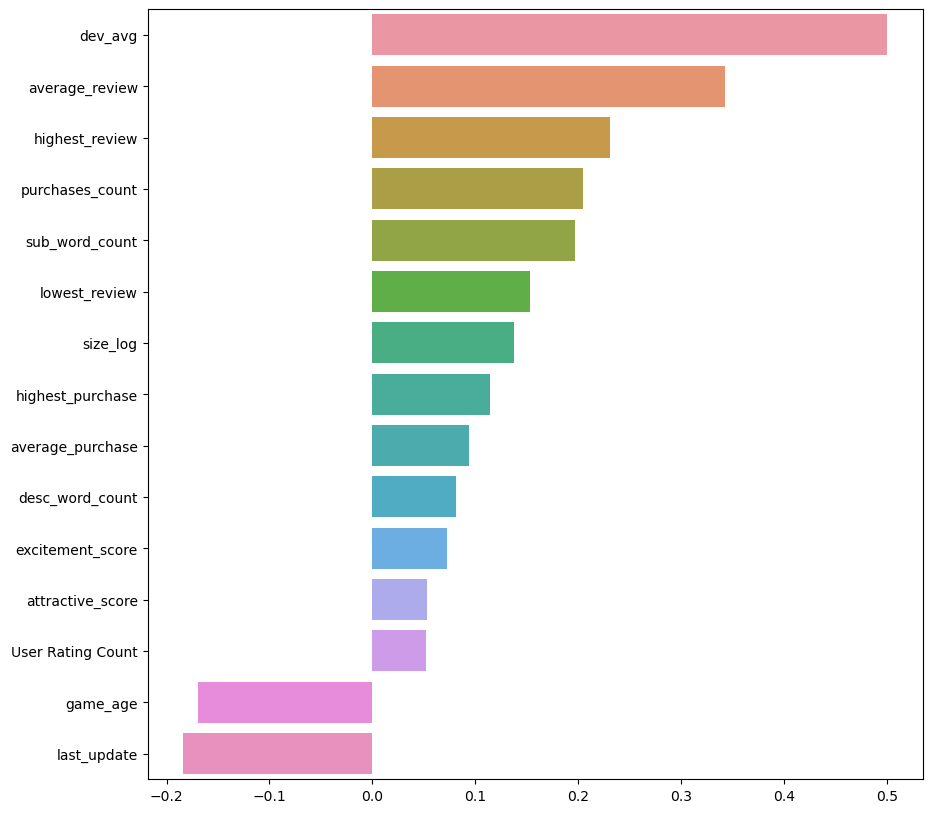

In [125]:
# plot correlation matrix between features and target

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)

corr = corr[abs(corr) > 0.05]

plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

In [126]:
# Scale the features
df_x_scaled = scale_data_std(df_x)
df_test_x_scaled = scale_data_std(df_test_x, test=True)

# Select the features
df_x_select = select_features(df_x_scaled, df_y)
df_test_x_select = select_features(df_test_x_scaled, df_test_y, test=True)

In [127]:
selector = pickle.load(open('encoders/classification/selector.pkl', 'rb'))
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

game_age
last_update
purchases_count
sub_word_count
dev_avg
lowest_review
highest_review
average_review


In [128]:
from lazypredict.Supervised import LazyClassifier

classifier = LazyClassifier(ignore_warnings=True, custom_metric=None)
models, predictions = classifier.fit(df_x_select, df_test_x_select, df_y, df_test_y)

models = models.sort_values('Accuracy', ascending=False)
models


100%|██████████| 29/29 [00:03<00:00,  7.71it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.68,0.49,None,0.67,0.32
RandomForestClassifier,0.68,0.52,None,0.67,0.55
AdaBoostClassifier,0.67,0.48,None,0.65,0.21
QuadraticDiscriminantAnalysis,0.66,0.51,None,0.65,0.01
LinearSVC,0.66,0.46,None,0.65,0.21
RidgeClassifierCV,0.66,0.46,None,0.64,0.02
ExtraTreesClassifier,0.66,0.49,None,0.65,0.37
RidgeClassifier,0.66,0.45,None,0.64,0.02
KNeighborsClassifier,0.66,0.49,None,0.65,0.04


In [129]:
# Train SVC model

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svc = SVC(kernel='rbf', C=0.8, gamma='auto', random_state=42)

svc.fit(df_x_select, df_y)

# Print the training accuracy score
svc_train_score = svc.score(df_x_select, df_y)
print('SVC Train Accuracy Score: {0}'.format(svc_train_score))

# Save the model
pickle.dump(svc, open('models/classification/svc.pkl', 'wb'))

# Make predictions
svc_pred = svc.predict(df_test_x_select)

# Calculate the accuracy score
svc_score = accuracy_score(df_test_y, svc_pred)
print('SVC Accuracy Score: {0}'.format(svc_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, svc_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, svc_pred))

plot_scores(svc_train_score, svc_score)

SVC Train Accuracy Score: 0.7321184510250569
SVC Accuracy Score: 0.6812386156648452
Confusion Matrix
[[  1  20   6]
 [  0 150  80]
 [  0  69 223]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        27
           1       0.63      0.65      0.64       230
           2       0.72      0.76      0.74       292

    accuracy                           0.68       549
   macro avg       0.78      0.48      0.48       549
weighted avg       0.70      0.68      0.67       549



In [130]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb = XGBClassifier(max_depth=3, random_state=42, 
                    n_estimators=10,  
                    colsample_bytree=0.3, 
                    subsample=0.7, 
                    reg_alpha=0.5, 
                    reg_lambda=10.0)

xgb.fit(df_x_select, df_y)

# Print the training accuracy score
xgb_train_score = xgb.score(df_x_select, df_y)
print('XGBoost Train Accuracy Score: {0}'.format(xgb_train_score))

# Save the model
pickle.dump(xgb, open('models/classification/xgb.pkl', 'wb'))

# Make predictions
xgb_pred = xgb.predict(df_test_x_select)

# Calculate the accuracy score
xgb_score = accuracy_score(df_test_y, xgb_pred)
print('XGBoost Accuracy Score: {0}'.format(xgb_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, xgb_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, xgb_pred))

XGBoost Train Accuracy Score: 0.7334851936218679
XGBoost Accuracy Score: 0.663023679417122
Confusion Matrix
[[  0  22   5]
 [  0 154  76]
 [  0  82 210]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.60      0.67      0.63       230
           2       0.72      0.72      0.72       292

    accuracy                           0.66       549
   macro avg       0.44      0.46      0.45       549
weighted avg       0.63      0.66      0.65       549



In [131]:
from catboost import CatBoostClassifier

# Train CatBoost model
cat = CatBoostClassifier(verbose=1000,
                         max_depth=4,
                         random_state=42,
                         boosting_type='Ordered',
                         border_count=32,
                         iterations=1100,
                         l2_leaf_reg=36,
                         learning_rate=0.02, 
                         random_strength=0.3)

cat.fit(df_x_select, df_y)

# Print the training accuracy score
cat_train_score = cat.score(df_x_select, df_y)
print('CatBoost Train Accuracy Score: {0}'.format(cat_train_score))

# Save the model
pickle.dump(cat, open('models/classification/cat.pkl', 'wb'))

# Make predictions
cat_pred = cat.predict(df_test_x_select)

# Calculate the accuracy score
cat_score = accuracy_score(df_test_y, cat_pred)
print('CatBoost Accuracy Score: {0}'.format(cat_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, cat_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, cat_pred))

0:	learn: 1.0878538	total: 5.66ms	remaining: 6.22s
1000:	learn: 0.5567227	total: 3.39s	remaining: 335ms
1099:	learn: 0.5521417	total: 3.72s	remaining: 0us
CatBoost Train Accuracy Score: 0.7471526195899773
CatBoost Accuracy Score: 0.6848816029143898
Confusion Matrix
[[  2  19   6]
 [  0 157  73]
 [  0  75 217]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.07      0.14        27
           1       0.63      0.68      0.65       230
           2       0.73      0.74      0.74       292

    accuracy                           0.68       549
   macro avg       0.79      0.50      0.51       549
weighted avg       0.70      0.68      0.67       549



In [132]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr = LogisticRegression(random_state=42, C=0.01)

lr.fit(df_x_select, df_y)

# Print the training accuracy score
lr_train_score = lr.score(df_x_select, df_y)
print('Logistic Regression Train Accuracy Score: {0}'.format(lr_train_score))

lr_pred = lr.predict(df_test_x_select)
lr_score = accuracy_score(df_test_y, lr_pred)

# Print the accuracy score
print('Logistic Regression Accuracy Score: {0}'.format(lr_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, lr_pred))

# Save the model
pickle.dump(lr, open('models/classification/lr.pkl', 'wb'))

Logistic Regression Train Accuracy Score: 0.7111617312072893
Logistic Regression Accuracy Score: 0.6648451730418944
Confusion Matrix
[[  0  21   6]
 [  0 147  83]
 [  0  74 218]]


In [133]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf = RandomForestClassifier(max_depth=4,
                            random_state=42,
                            n_estimators=400,
                            min_samples_leaf=2,
                            min_samples_split=5,
                            max_features='auto',
                            bootstrap=True)
rf.fit(df_x_select, df_y)

# Print the training accuracy score
rf_train_score = rf.score(df_x_select, df_y)
print('Random Forest Train Accuracy Score: {0}'.format(rf_train_score))

# Save the model
pickle.dump(rf, open('models/classification/rf.pkl', 'wb'))

# Make predictions
rf_pred = rf.predict(df_test_x_select)

# Calculate the accuracy score
rf_score = accuracy_score(df_test_y, rf_pred)

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, rf_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, rf_pred))

# Display the scores
plot_scores(rf_train_score, rf_score)

Random Forest Train Accuracy Score: 0.7330296127562642
Confusion Matrix
[[  0  21   6]
 [  0 147  83]
 [  0  64 228]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.63      0.64      0.64       230
           2       0.72      0.78      0.75       292

    accuracy                           0.68       549
   macro avg       0.45      0.47      0.46       549
weighted avg       0.65      0.68      0.66       549



In [134]:
# Random Forest Classifier with hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Create a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

"""
Be careful! 
if you are running this on your local machine, you probably want to adjust n_jobs
Use os.cpu_count() to get the number of cores on your machine, and leave some for other tasks
"""

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1)
grid_search.fit(df_x_select, df_y)

# Print best hyperparameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train final model with best hyperparameters on entire dataset
best_clf = RandomForestClassifier(random_state=42, **grid_search.best_params_)
best_clf.fit(df_x_select, df_y)

# Print the training accuracy score
rf_train_score = best_clf.score(df_x_select, df_y)
print('Random Forest Train Accuracy Score: {0}'.format(rf_train_score))

# Save the model 
pickle.dump(best_clf, open('models/classification/rf_hyper.pkl', 'wb'))

# Make predictions
rf_pred = best_clf.predict(df_test_x_select)

# Calculate the accuracy score
rf_score = accuracy_score(df_test_y, rf_pred)

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, rf_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, rf_pred))

# Display the scores
plot_scores(rf_train_score, rf_score)

Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: 0.7029612756264235
Random Forest Train Accuracy Score: 0.7211845102505695
Confusion Matrix
[[  0  20   7]
 [  0 139  91]
 [  0  54 238]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.65      0.60      0.63       230
           2       0.71      0.82      0.76       292

    accuracy                           0.69       549
   macro avg       0.45      0.47      0.46       549
weighted avg       0.65      0.69      0.67       549

